# SPOmiAlign Demo: SM (H5AD) to ST (H5AD) Alignment

**任务**：将空间代谢组 (SM) 数据对齐到空间转录组 (ST) 数据，并进行表达量重分配。
**流程**：
1. **Rasterization**: H5AD -> 图像
2. **Alignment**: 图像配准
3. **Visualization**: 叠加检查
4. **Reassignment**: 生成最终 H5AD

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

sys.path.append("../../SPOmiAlign")
from roma import align_and_process_images
from data_preprocessing import rasterize_h5ad_to_image
from reassignment import spomialign_reassignment


plt.rcParams['figure.dpi'] = 100

✅ Successfully imported 'rasterize_h5ad_to_image' from data_process.py


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.9.0+cu128 with CUDA 1208 (you have 2.7.1+cu126)
    Python  3.10.19 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🚀 正在栅格化 H5AD...
key: AxisArrays with keys: X_pca, X_umap, pixel, spatial, spatial_spot spatial
X RANGE: 1360.0 2564.0
Y RANGE: 1360.0 2608.0
✅ PNG 已保存：../../output/h5ad_2_h5ad/sm2st/st.png（3648×3436，background=white，shape=square，radius=15）
key: AxisArrays with keys: X_pca, X_umap, pixel, spatial, spatial_spot spatial
X RANGE: 500.0 2456.0
Y RANGE: 500.0 2510.0
✅ PNG 已保存：../../output/h5ad_2_h5ad/sm2st/sm.png（3567×3566，background=white，shape=square，radius=12）


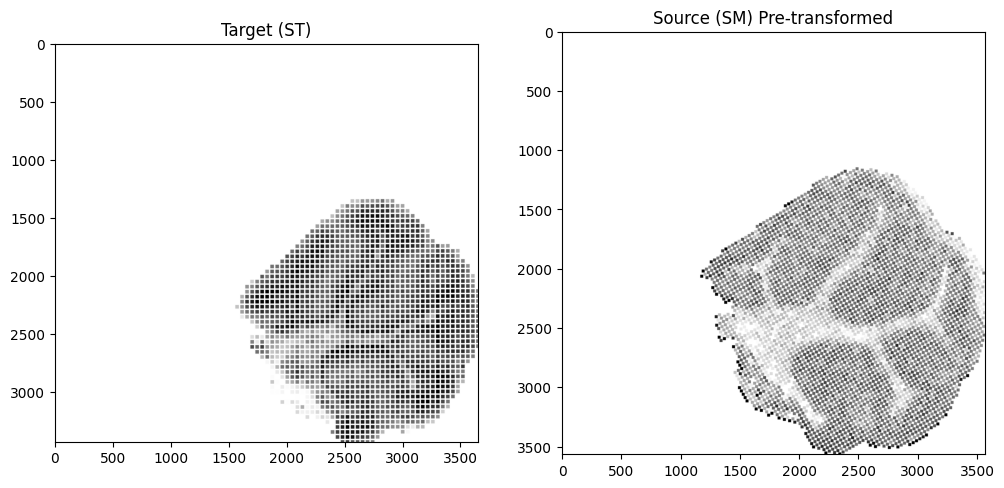

In [2]:
# --- 路径配置 ---
DATA_DIR = "../../SPOmiAlign_Repro"
SAVE_DIR = "../../output"
SAVE_PATH = os.path.join(SAVE_DIR, "h5ad_2_h5ad", "sm2st")
os.makedirs(SAVE_PATH, exist_ok=True)

h5ad_img1_path = os.path.join(DATA_DIR, "output_h5ad", "st_withIntensity.h5ad") # Target
h5ad_img2_path = os.path.join(DATA_DIR, "output_h5ad", "sm_withIntensity.h5ad") # Source

# --- 步骤 1: H5AD 转图像 ---
print("🚀 正在栅格化 H5AD...")
Gen_img1_path = os.path.join(SAVE_PATH, "st.png")
Gen_img2_path = os.path.join(SAVE_PATH, "sm.png")

# Target
rasterize_h5ad_to_image(
    input_h5ad=h5ad_img1_path, output_png=Gen_img1_path,
    background="white", point_shape="square", radius=15,
    rotate=0.0, scale=1.0, enhance=False
)
# Source (带预旋转 60度)
_,origin = rasterize_h5ad_to_image(
    input_h5ad=h5ad_img2_path, output_png=Gen_img2_path,
    background="white", point_shape="square", radius=12,
    rotate=60.0, scale=0.6, enhance=False
)

# 可视化生成的中间图像
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(cv2.imread(Gen_img1_path)[...,::-1]) # BGR->RGB
ax[0].set_title("Target (ST)")
ax[1].imshow(cv2.imread(Gen_img2_path)[...,::-1])
ax[1].set_title("Source (SM) Pre-transformed")
plt.show()

🚀 开始配准...
Using device: cuda:0


2026-01-05 15:22:21.203 | INFO     | romatch.models.model_zoo.roma_models:roma_model:61 - Using coarse resolution (560, 560), and upsample res (864, 1152)


Running RoMa matching...
Estimating affine+bspline transform...
Warping images...
Padding fill color (from 10,10): [255, 255, 255]
Processing H5AD coordinates...
🔄 Applying manual pre-transform: rotate=60.0°, scale=0.6
📝 Columns not found or not specified. Updating adata.obsm['spatial']
📝 Columns not found or not specified. Updating adata.obsm['spatial']
📝 Columns not found or not specified. Updating adata.obsm['spatial']
📝 Columns not found or not specified. Updating adata.obsm['spatial']
✅ Saved transformed H5AD to ../../output/h5ad_2_h5ad/sm2st/alignment/transformed.h5ad


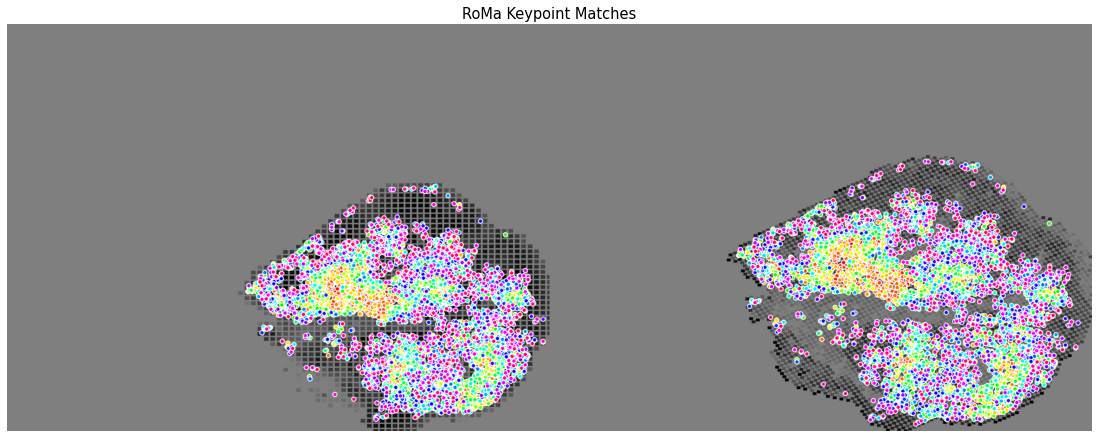

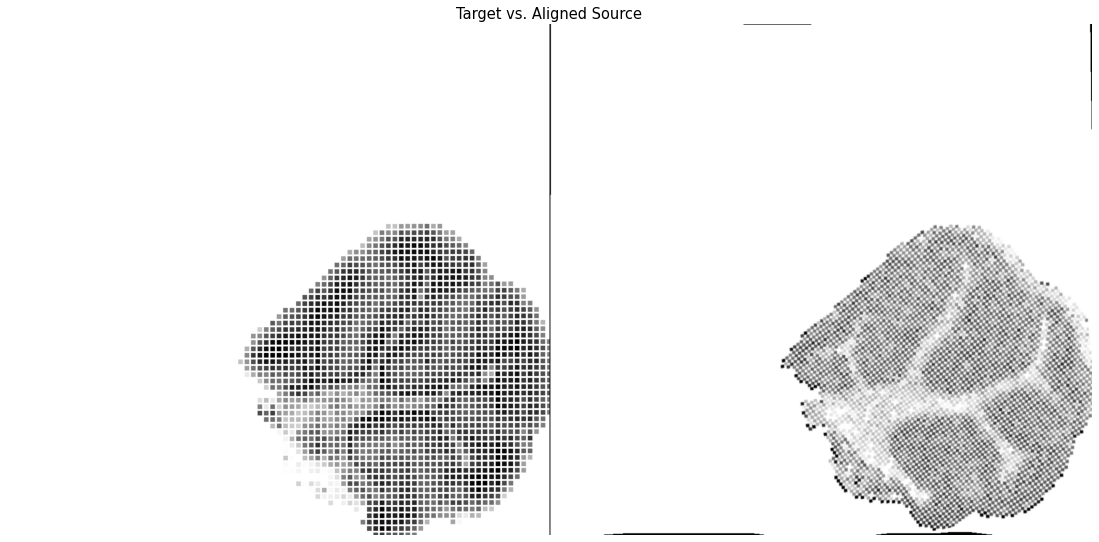

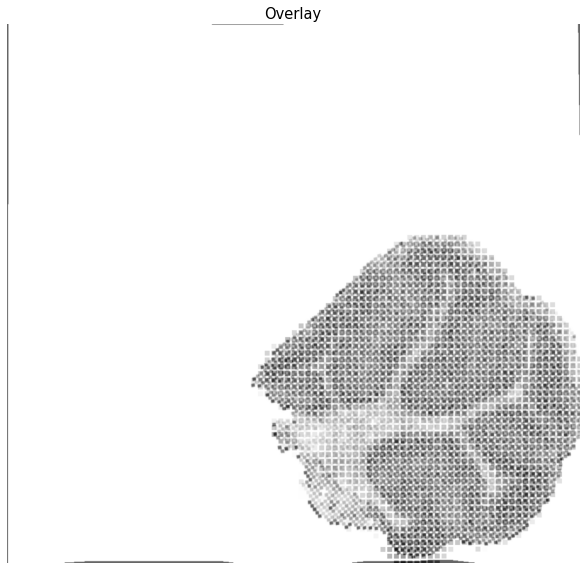

Alignment runtime: 6.6406 seconds
Done. Results saved to ../../output/h5ad_2_h5ad/sm2st/alignment
key: AxisArrays with keys: X_pca, X_umap, pixel, spatial, spatial_spot spatial
X RANGE: 1822.2019138620237 3477.77517606135
Y RANGE: 1843.3319721393023 3494.632675648142
✅ PNG 已保存：../../output/h5ad_2_h5ad/sm2st/alignment/transformed_h5ad.png（3657×3402，background=white，shape=square，radius=12）
✅ 配准完成。


In [3]:
# --- 步骤 2: 配准 ---
print("🚀 开始配准...")
save_path_alignment = os.path.join(SAVE_PATH, "alignment")
transformed_h5ad_path = os.path.join(save_path_alignment, "transformed.h5ad") 
transformed_h5ad_img_path = os.path.join(save_path_alignment, "transformed_h5ad.png")

# 运行配准核心函数
align_and_process_images(
    img1_path=Gen_img1_path, 
    img2_path=Gen_img2_path, 
    h5ad_path=h5ad_img2_path,  
    method='affine+bspline', 
    output_dir=save_path_alignment,
    rotate=60.0, 
    scale=0.6,
    origin=origin 
)

# 将配准后的 H5AD 再次转为图片以供验证
rasterize_h5ad_to_image(
    input_h5ad=transformed_h5ad_path,
    output_png=transformed_h5ad_img_path,
    background="white", point_shape="square", radius=12,
    rotate=0.0, scale=1.0, enhance=False
)
print("✅ 配准完成。")

🎨 生成叠加图...


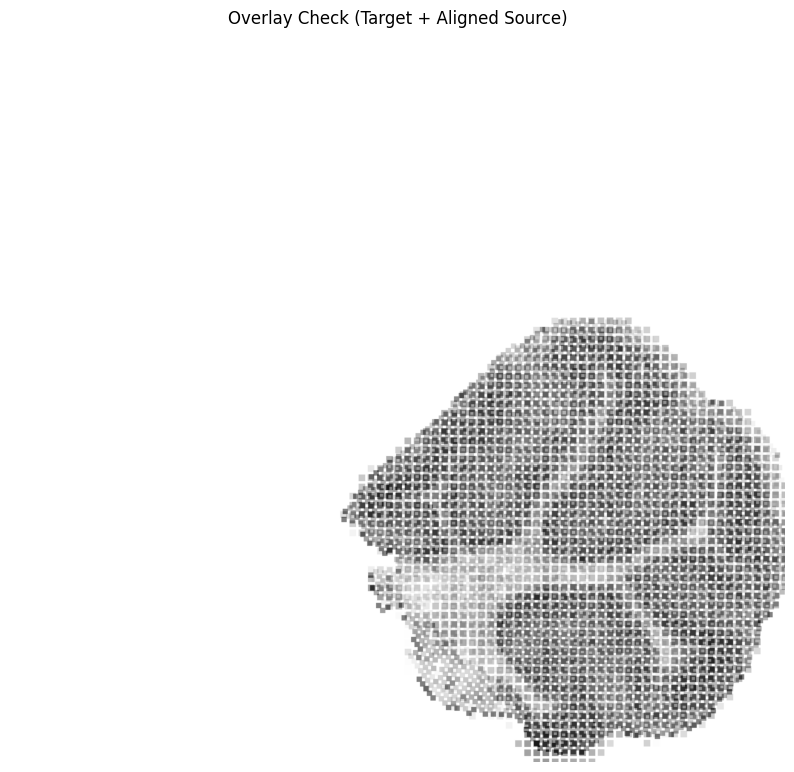

In [4]:
# --- 步骤 3: 叠加可视化 ---
print("🎨 生成叠加图...")

target_img = cv2.imread(Gen_img1_path)
# 读取为灰度图作为 Mask
aligned_h5ad_gray = cv2.imread(transformed_h5ad_img_path, cv2.IMREAD_GRAYSCALE)

if target_img is not None and aligned_h5ad_gray is not None:
    # 转回 BGR
    aligned_h5ad_bgr = cv2.cvtColor(aligned_h5ad_gray, cv2.COLOR_GRAY2BGR)
    
    # 创建白色画布
    t_h, t_w = target_img.shape[:2]
    canvas = np.full((t_h, t_w, 3), 255, dtype=np.uint8)
    
    # 放置图像
    h, w = aligned_h5ad_bgr.shape[:2]
    canvas[:min(t_h,h), :min(t_w,w)] = aligned_h5ad_bgr[:min(t_h,h), :min(t_w,w)]

    # 混合叠加
    overlay = cv2.addWeighted(target_img, 0.5, canvas, 0.5, 0)
    
    # 保存并显示
    out_overlay = os.path.join(save_path_alignment, "overlay_check.png")
    cv2.imwrite(out_overlay, overlay)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay Check (Target + Aligned Source)")
    plt.axis('off')
    plt.show()

In [5]:
# --- 步骤 4: Reassignment ---
print("🧬 执行数据重分配...")

final_h5ad = os.path.join(SAVE_PATH, "sm2st_final_reassigned.h5ad")
map_csv = os.path.join(SAVE_PATH, "sm2st_mapping.csv")

# 请确保你已经有 spomialign_reassignment 函数 (来自 reassignment.py)
spomialign_reassignment(
    s1_h5ad=h5ad_img1_path,         
    s2_h5ad=transformed_h5ad_path,  
    out_h5ad=final_h5ad,
    map_csv=map_csv,
    id_col="id",
    cluster_col="cluster",
    s2_cluster_col=["s2_cluster_col"], 
    scale_by_mapping_factor=True
)
print(f"✨ 最终文件已生成: {final_h5ad}")

🧬 执行数据重分配...
读取 S1 h5ad: ../../SPOmiAlign_Repro/output_h5ad/st_withIntensity.h5ad
读取 S2 h5ad: ../../output/h5ad_2_h5ad/sm2st/alignment/transformed.h5ad
S1 有效坐标点数: 1677 / 1677
S2 有效坐标点数: 3908 / 3908
S1 内部最近邻距离均值: 43.0018
S2 内部最近邻距离均值: 26.9610

自动判断：S1 = 低分辨率，S2 = 高分辨率
低分辨率切片内部最近邻最大距离 d_ref_max = 44.0000

--- 高分辨率 → 低分辨率 最近邻搜索 ---
距离过滤：删除 0 个高分辨率点（dist > 2 * d_ref_max）。

映射表前几行：
   high_id low_id       high_x       high_y  low_x  low_y   distance  \
0  spot-49   reg1  3477.775176  1822.201914   3473   1833  11.806819   
1  spot-50   reg1  3494.632676  1843.331972   3473   1833  23.973367   
2  spot-51   reg1  3511.614391  1864.378544   3517   1876  12.808709   
3  spot-52   reg1  3528.607060  1885.415170   3517   1876  14.945544   
4  spot-53   reg1  3545.495890  1906.506481   3560   1919  19.143073   

   high_index  low_index  
0           0        271  
1           1        271  
2           2        308  
3           3        308  
4           4        348  

中间映射表已保存：../../output/h5

/data/Newdisk/Bigmodel/zxm/Match/RoMa-main/RoMa-main/20251226/Code/demo/notebook/../../SPOmiAlign/reassignment.py:59: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "spatial" not in adata_s1.obsm_keys():
/data/Newdisk/Bigmodel/zxm/Match/RoMa-main/RoMa-main/20251226/Code/demo/notebook/../../SPOmiAlign/reassignment.py:61: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "spatial" not in adata_s2.obsm_keys():


ℹ️ X_new 为 coo_matrix，转换为 csr_matrix 以便写入 h5ad。
ℹ️ 低分辨率 h5ad 中无 obs['Manual_annotation']，跳过写入 Manual_annotation。
⚠️ 高分辨率(S2) h5ad 中无 obs['s2_cluster_col']，跳过该列。

✅ 新 h5ad 已保存：../../output/h5ad_2_h5ad/sm2st/sm2st_final_reassigned.h5ad
   形状：3908 × 16116
   obs 列包含： ['low_id', 'high_id', 'cluster', 'knn_dist']
   obsm 包含： ['spatial']
   cluster dtype: category
✨ 最终文件已生成: ../../output/h5ad_2_h5ad/sm2st/sm2st_final_reassigned.h5ad
